In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# prevent results from being clipped
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# set up consistent color palette across all notebooks
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")  # 8 colors available

# load the cleaned pokemon dataset
df = pd.read_csv('pokemon_cleaned.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# define base stats for clustering
base_stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']
print(f"\nclustering features: {base_stats_cols}")

# function to convert stat names to short labels for graphs
def get_short_stat_label(stat_name):
    label_map = {
        'Health Stat': 'hp',
        'Attack Stat': 'atk',
        'Defense Stat': 'def',
        'Special Attack Stat': 'sp. atk',
        'Special Defense Stat': 'sp. def',
        'Speed Stat': 'speed'
    }
    return label_map.get(stat_name, stat_name.replace(' Stat', '').lower())

dataset loaded: 1025 rows, 43 columns

clustering features: ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']


## Data Preprocessing for Clustering

In [2]:
# create specialization features based on stat proportions
# this focuses on HOW stats are distributed, not their absolute values

# calculate stat proportions (percentage of total stats)
stat_totals = df[base_stats_cols].sum(axis=1)
stat_proportions = df[base_stats_cols].div(stat_totals, axis=0)

# add column names
stat_proportion_cols = [col.replace(' Stat', ' Proportion') for col in base_stats_cols]
for i, col in enumerate(base_stats_cols):
    df[stat_proportion_cols[i]] = stat_proportions.iloc[:, i]

# calculate specialization metrics
df['Offense Focus'] = (df['Attack Stat'] + df['Special Attack Stat']) / df['Base Stat Total']
df['Defense Focus'] = (df['Defense Stat'] + df['Special Defense Stat']) / df['Base Stat Total']
df['Speed Focus'] = df['Speed Stat'] / df['Base Stat Total']
df['Health Focus'] = df['Health Stat'] / df['Base Stat Total']
df['Physical vs Special'] = (df['Attack Stat'] - df['Special Attack Stat']) / (df['Attack Stat'] + df['Special Attack Stat'] + 1)  # +1 to avoid division by zero
df['Offensive vs Defensive'] = (df['Attack Stat'] + df['Special Attack Stat'] - df['Defense Stat'] - df['Special Defense Stat']) / df['Base Stat Total']

# use proportions for clustering (removes power level bias)
specialization_features = stat_proportion_cols + ['Physical vs Special', 'Offensive vs Defensive']
X_scaled = df[specialization_features].values

# standardize specialization features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)

print(f"feature matrix shape: {X_scaled.shape}")
print(f"\nspecialization features used:")
for feat in specialization_features:
    print(f"  • {feat}")
    
print(f"\nclustering approach: stat DISTRIBUTION patterns (not absolute power)")
print(f"result: weak and strong pokemon with similar roles cluster together")

feature matrix shape: (1025, 8)

specialization features used:
  • Health Proportion
  • Attack Proportion
  • Defense Proportion
  • Special Attack Proportion
  • Special Defense Proportion
  • Speed Proportion
  • Physical vs Special
  • Offensive vs Defensive

clustering approach: stat DISTRIBUTION patterns (not absolute power)
result: weak and strong pokemon with similar roles cluster together


## Elbow Method for Optimal K

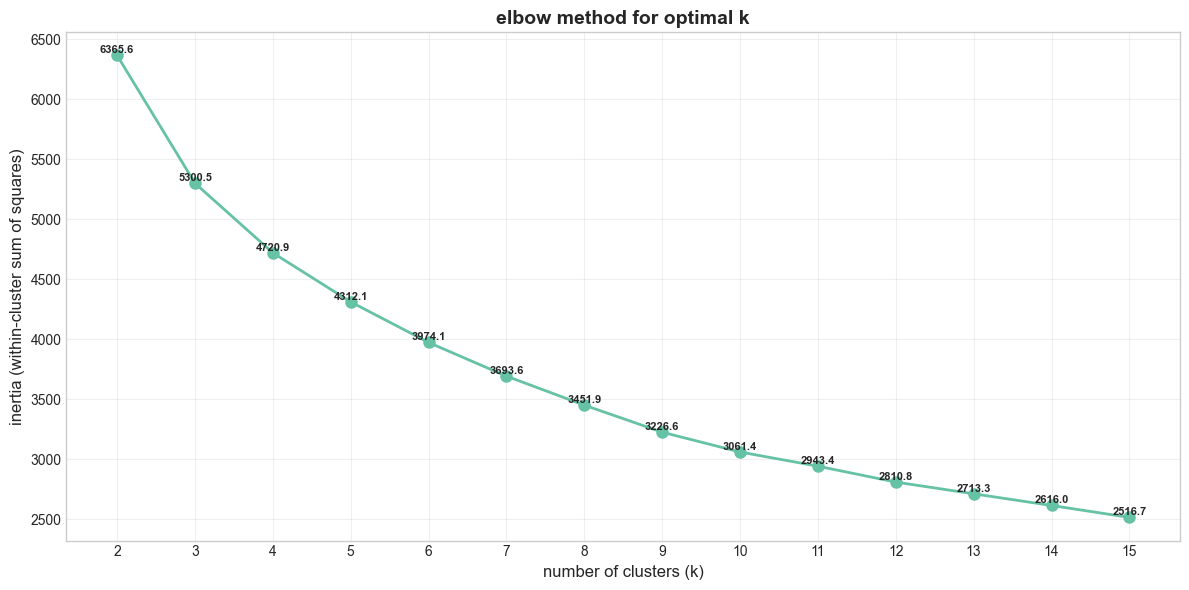

elbow method results:
  k=2: inertia=6365.63
  k=3: inertia=5300.55
  k=4: inertia=4720.88
  k=5: inertia=4312.10
  k=6: inertia=3974.09
  k=7: inertia=3693.56
  k=8: inertia=3451.95
  k=9: inertia=3226.64
  k=10: inertia=3061.43
  k=11: inertia=2943.39
  k=12: inertia=2810.84
  k=13: inertia=2713.34
  k=14: inertia=2615.98
  k=15: inertia=2516.66


In [3]:
# elbow method - calculate inertia for different k values
inertias = []
K_range = range(2, 16)  # focused range for archetype identification

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# plot elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertias, 'o-', color=presentation_palette[0], linewidth=2, markersize=8)
plt.xlabel('number of clusters (k)', fontsize=12)
plt.ylabel('inertia (within-cluster sum of squares)', fontsize=12)
plt.title('elbow method for optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# add value labels for all points
for i, (k, inertia) in enumerate(zip(K_range, inertias)):
    plt.text(k, inertia + 0.5, f'{inertia:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/clustering/elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("elbow method results:")
for k, inertia in zip(K_range, inertias):
    print(f"  k={k}: inertia={inertia:.2f}")

## Silhouette Analysis

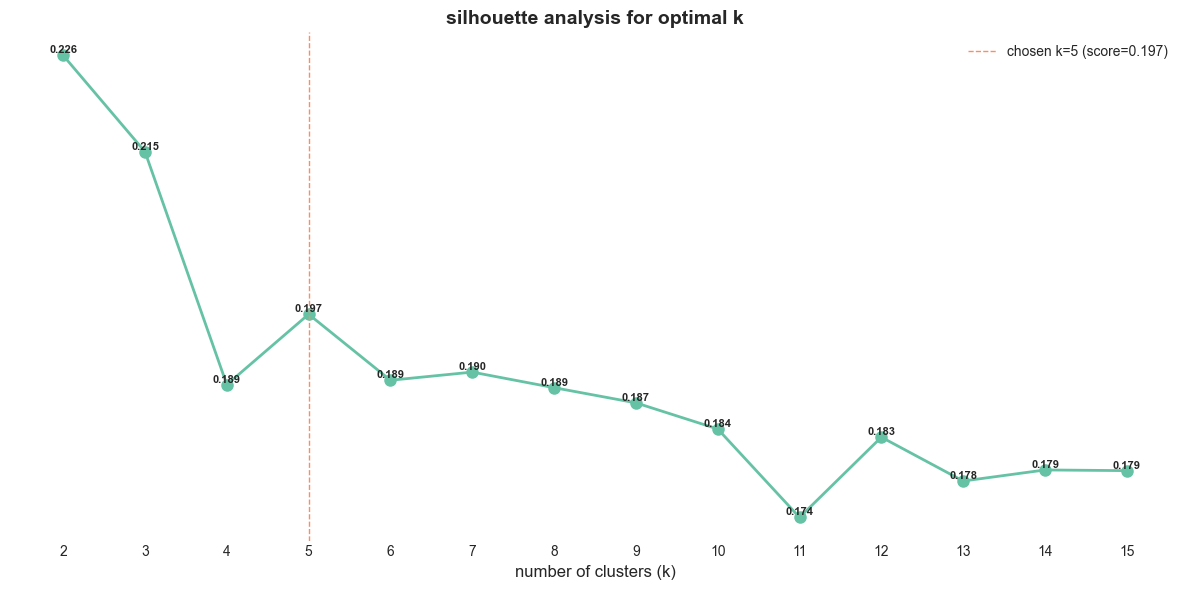

silhouette analysis results:
  k=2: silhouette score=0.2261
  k=3: silhouette score=0.2152
  k=4: silhouette score=0.1890
  k=5: silhouette score=0.1969
  k=6: silhouette score=0.1895
  k=7: silhouette score=0.1904
  k=8: silhouette score=0.1886
  k=9: silhouette score=0.1869
  k=10: silhouette score=0.1840
  k=11: silhouette score=0.1740
  k=12: silhouette score=0.1831
  k=13: silhouette score=0.1781
  k=14: silhouette score=0.1794
  k=15: silhouette score=0.1793

chosen k for archetypes: 5 (score=0.1969)


In [4]:
# silhouette score for different k values
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(K_range, silhouette_scores, 'o-', color=presentation_palette[0], linewidth=2, markersize=8)
plt.xlabel('number of clusters (k)', fontsize=12)
plt.ylabel('silhouette score', fontsize=12)
plt.title('silhouette analysis for optimal k', fontsize=14, fontweight='bold')

# remove outline, y axis, and grid
ax = plt.gca()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_visible(False)
plt.grid(False)
plt.xticks(K_range)

# find best k (prefer 5-10 for meaningful archetypes)
min_k_threshold = 5
max_k_threshold = 10
valid_k_indices = [i for i, k in enumerate(K_range) if min_k_threshold <= k <= max_k_threshold]
best_k_idx = valid_k_indices[np.argmax([silhouette_scores[i] for i in valid_k_indices])]
best_k = list(K_range)[best_k_idx]
best_score = silhouette_scores[best_k_idx]

plt.axvline(x=best_k, color=presentation_palette[1], linestyle='--', linewidth=1, 
            label=f'chosen k={best_k} (score={best_score:.3f})')

# add value labels for all points
for i, (k, score) in enumerate(zip(K_range, silhouette_scores)):
    plt.text(k, score, f'{score:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.savefig('figures/clustering/silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("silhouette analysis results:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: silhouette score={score:.4f}")
print(f"\nchosen k for archetypes: {best_k} (score={best_score:.4f})")

## KMeans Clustering with Optimal K

In [5]:
# use optimal k from silhouette analysis
optimal_k = best_k

# perform specialization-based kmeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"kmeans clustering with k={optimal_k}")
print(f"\ncluster distribution:")
cluster_counts = df['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  cluster {cluster}: {count} pokemon ({count/len(df)*100:.1f}%)")

# silhouette score for optimal clustering
final_silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"\nfinal silhouette score: {final_silhouette:.4f}")

# analyze cluster characteristics using ORIGINAL stats (not proportions)
cluster_stats = df.groupby('Cluster')[base_stats_cols + ['Base Stat Total']].mean().round(1)

# create display version with short labels
cluster_stats_display = cluster_stats.copy()
cluster_stats_display.columns = [get_short_stat_label(col) if col in base_stats_cols else col for col in cluster_stats_display.columns]

print("\naverage stats by cluster:")
display(cluster_stats_display)

# also show the specialization features
cluster_features = df.groupby('Cluster')[['Offense Focus', 'Defense Focus', 'Speed Focus', 'Health Focus', 'Physical vs Special', 'Offensive vs Defensive']].mean().round(3)
print("\nspecialization patterns by cluster:")
display(cluster_features)

kmeans clustering with k=5

cluster distribution:
  cluster 0: 218 pokemon (21.3%)
  cluster 1: 292 pokemon (28.5%)
  cluster 2: 62 pokemon (6.0%)
  cluster 3: 165 pokemon (16.1%)
  cluster 4: 288 pokemon (28.1%)

final silhouette score: 0.1969

average stats by cluster:


,hp,atk,def,sp. atk,sp. def,speed,Base Stat Total
Cluster,,,,,,,
0,72.2,98.4,94.5,52.8,65.0,55.1,438.1
1,68.4,66.1,68.2,97.9,77.0,73.2,450.8
2,117.4,69.5,58.5,61.2,63.2,42.4,412.3
3,60.9,57.0,85.9,58.6,92.2,56.8,411.3
4,66.6,93.2,60.0,68.1,59.3,84.5,431.8



specialization patterns by cluster:


,Offense Focus,Defense Focus,Speed Focus,Health Focus,Physical vs Special,Offensive vs Defensive
Cluster,,,,,,
0,0.345,0.364,0.126,0.166,0.298,-0.019
1,0.362,0.322,0.163,0.153,-0.196,0.040
2,0.316,0.296,0.103,0.285,0.046,0.019
3,0.278,0.431,0.143,0.149,-0.013,-0.153
4,0.370,0.276,0.199,0.155,0.164,0.095


## Cluster Characteristics: Bar Charts and Heatmap

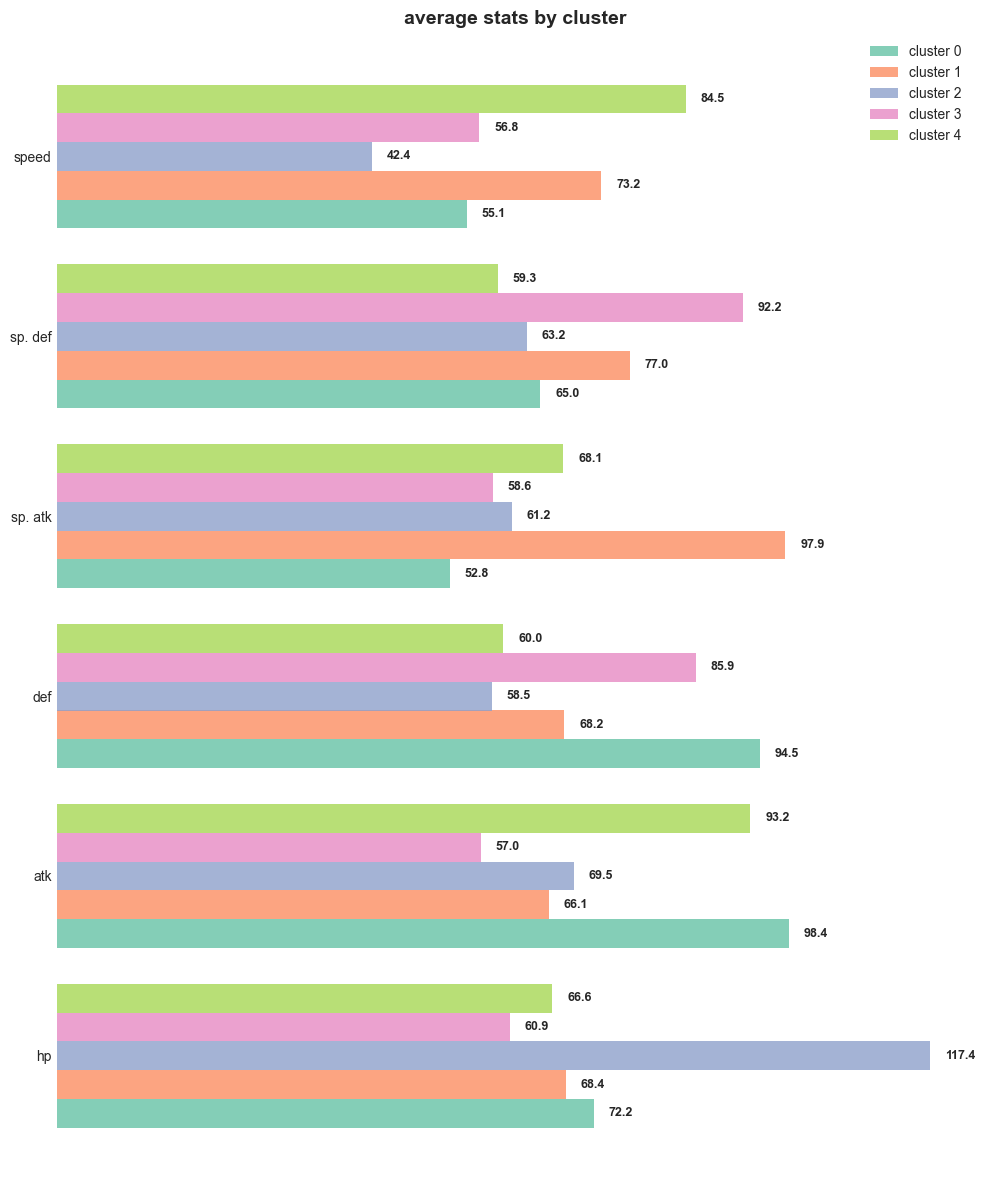

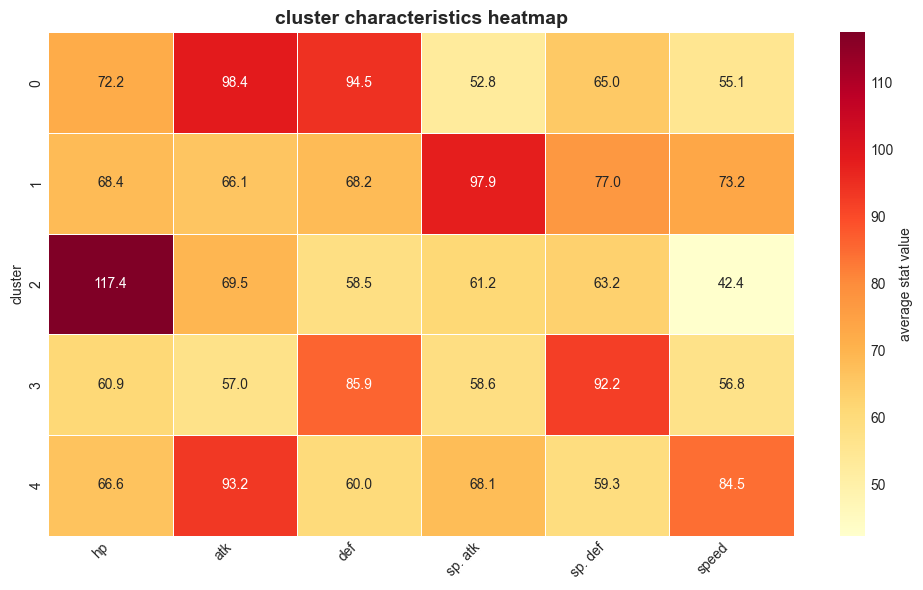

heatmap shows each cluster's stat profile
helps identify which stats define each cluster


In [6]:
# visualize cluster characteristics with bar chart
plt.figure(figsize=(10, 12))
cluster_stats_plot = cluster_stats[base_stats_cols].T
y = np.arange(len(base_stats_cols))
height = 0.8 / optimal_k

for i in range(optimal_k):
    bars = plt.barh(y + i * height, cluster_stats_plot[i], height, 
                    label=f'cluster {i}', color=presentation_palette[i % len(presentation_palette)], alpha=0.8)
    
    # add value labels directly on bars
    for bar, value in zip(bars, cluster_stats_plot[i]):
        plt.text(value + 2, bar.get_y() + bar.get_height()/2, f'{value:.1f}', 
                ha='left', va='center', fontsize=9, fontweight='bold')

plt.title('average stats by cluster', fontsize=14, fontweight='bold')
plt.yticks(y + height * (optimal_k - 1) / 2, [get_short_stat_label(s) for s in base_stats_cols])
plt.legend()
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(True)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/clustering/cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

# heatmap of cluster characteristics
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cluster_stats[base_stats_cols], annot=True, fmt='.1f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'average stat value'})
plt.title('cluster characteristics heatmap', fontsize=14, fontweight='bold')
plt.ylabel('cluster')
ax.set_xticklabels([get_short_stat_label(s) for s in base_stats_cols], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/clustering/cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("heatmap shows each cluster's stat profile")
print("helps identify which stats define each cluster")

## Understanding What Defines Each Cluster

cluster deviations from overall mean (in standard deviations):

cluster 0:
  size: 218 pokemon
  defining characteristics (ordered by importance):
    • def: +0.67 std (above average)
    • atk: +0.60 std (above average)
    • sp. atk: -0.59 std (below average)
    • speed: -0.43 std (below average)
    • sp. def: -0.22 std (below average)
    • hp: +0.06 std (above average)

cluster 1:
  size: 292 pokemon
  defining characteristics (ordered by importance):
    • sp. atk: +0.84 std (above average)
    • atk: -0.42 std (below average)
    • sp. def: +0.21 std (above average)
    • def: -0.18 std (below average)
    • speed: +0.17 std (above average)
    • hp: -0.08 std (below average)

cluster 2:
  size: 62 pokemon
  defining characteristics (ordered by importance):
    • hp: +1.71 std (above average)
    • speed: -0.85 std (below average)
    • def: -0.50 std (below average)
    • sp. atk: -0.32 std (below average)
    • atk: -0.31 std (below average)
    • sp. def: -0.28 std (below av

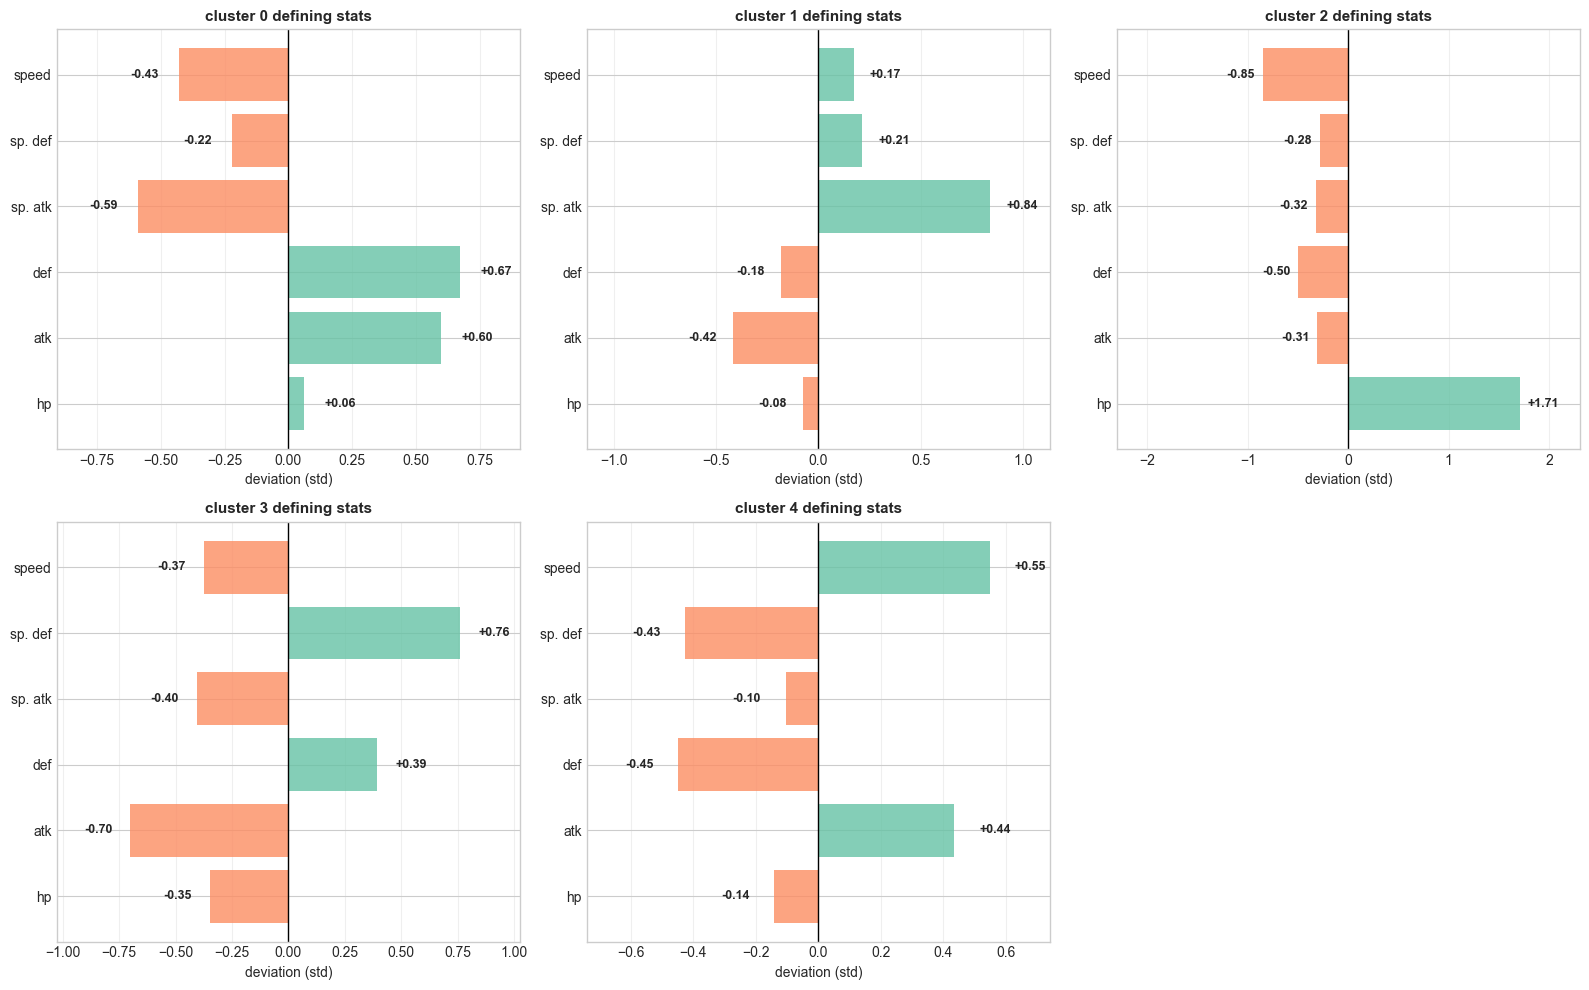


interpretation: positive values = above average, negative = below average
larger absolute values = more important for defining that cluster


In [7]:
# analyze what makes each cluster unique
# for visualization, we'll show how actual base stats deviate from the mean

# calculate overall mean and std for base stats (not scaled)
X_base_stats = df[base_stats_cols].values
overall_mean_stats = X_base_stats.mean(axis=0)
overall_std_stats = X_base_stats.std(axis=0)

# get cluster average stats
cluster_avg_stats = cluster_stats[base_stats_cols].values

# calculate deviation from mean for each cluster (in standard deviations)
print("cluster deviations from overall mean (in standard deviations):")
print("=" * 80)

cluster_deviations = []
for cluster in range(optimal_k):
    avg_stats = cluster_avg_stats[cluster]
    deviations = (avg_stats - overall_mean_stats) / overall_std_stats  # normalize to std deviations
    
    print(f"\ncluster {cluster}:")
    print(f"  size: {cluster_counts[cluster]} pokemon")
    
    # sort by absolute deviation to find most distinguishing features
    stat_importance = [(base_stats_cols[i], deviations[i]) for i in range(len(base_stats_cols))]
    stat_importance_sorted = sorted(stat_importance, key=lambda x: abs(x[1]), reverse=True)
    
    print(f"  defining characteristics (ordered by importance):")
    for stat, dev in stat_importance_sorted:
        direction = "above" if dev > 0 else "below"
        print(f"    • {get_short_stat_label(stat)}: {dev:+.2f} std ({direction} average)")
    
    cluster_deviations.append({
        'cluster': cluster,
        'most_positive': get_short_stat_label(stat_importance_sorted[0][0]) if stat_importance_sorted[0][1] > 0 else get_short_stat_label(stat_importance_sorted[1][0]),
        'most_negative': get_short_stat_label(stat_importance_sorted[0][0]) if stat_importance_sorted[0][1] < 0 else get_short_stat_label(stat_importance_sorted[-1][0]),
        'primary_deviation': stat_importance_sorted[0][1],
        'secondary_deviation': stat_importance_sorted[1][1]
    })

# visualize cluster centers as deviations from mean
fig, axes = plt.subplots(2, (optimal_k + 1) // 2, figsize=(16, 10))
axes = axes.flatten() if optimal_k > 1 else [axes]

for cluster in range(optimal_k):
    avg_stats = cluster_avg_stats[cluster]
    deviations = (avg_stats - overall_mean_stats) / overall_std_stats  # normalize to std deviations
    
    colors = [presentation_palette[0] if d > 0 else presentation_palette[1] for d in deviations]
    bars = axes[cluster].barh(range(len(base_stats_cols)), deviations, color=colors, alpha=0.8)
    axes[cluster].set_yticks(range(len(base_stats_cols)))
    axes[cluster].set_yticklabels([get_short_stat_label(s) for s in base_stats_cols])
    axes[cluster].set_xlabel('deviation (std)', fontsize=10)
    axes[cluster].set_title(f'cluster {cluster} defining stats', fontweight='bold', fontsize=11)
    axes[cluster].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[cluster].grid(True, alpha=0.3, axis='x')
    
    # set x-axis limits with extra padding for labels (increased to prevent cutoff)
    max_abs_dev = max(abs(deviations.min()), abs(deviations.max()))
    axes[cluster].set_xlim(-max_abs_dev * 1.35, max_abs_dev * 1.35)
    
    # add value labels
    for i, (bar, dev) in enumerate(zip(bars, deviations)):
        x_pos = dev + (0.08 if dev > 0 else -0.08)
        axes[cluster].text(x_pos, i, f'{dev:+.2f}', ha='left' if dev > 0 else 'right', 
                          va='center', fontsize=9, fontweight='bold')

# hide extra subplots if optimal_k is odd
if optimal_k % 2 == 1:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('figures/clustering/cluster_deviations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("interpretation: positive values = above average, negative = below average")
print("larger absolute values = more important for defining that cluster")

## Radar Charts: Visual Cluster Profiles

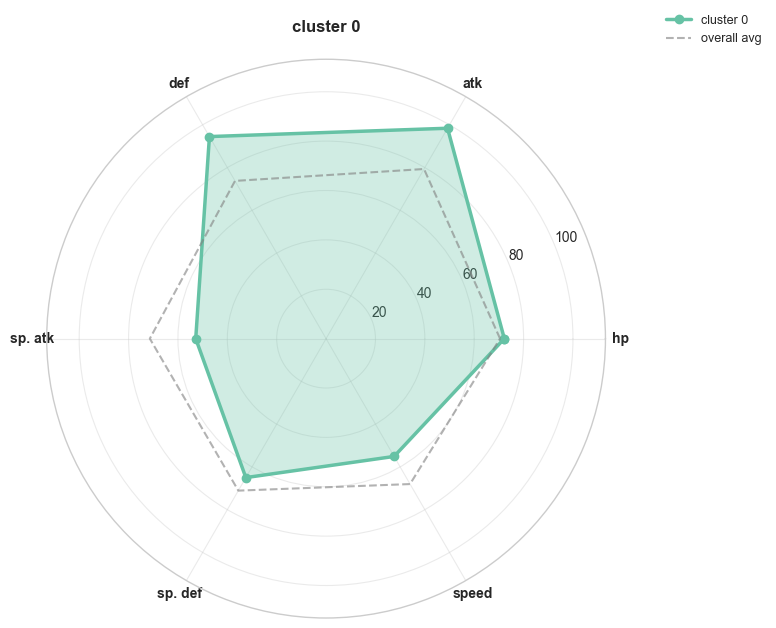

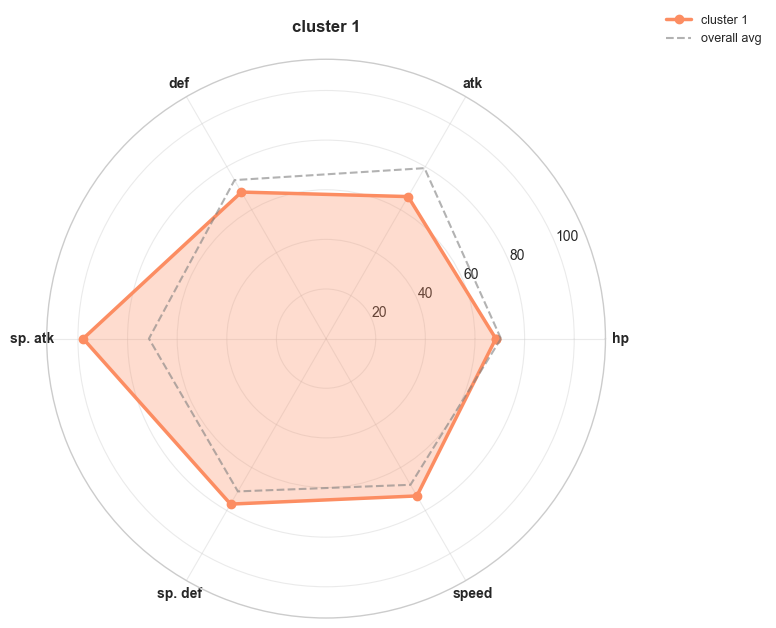

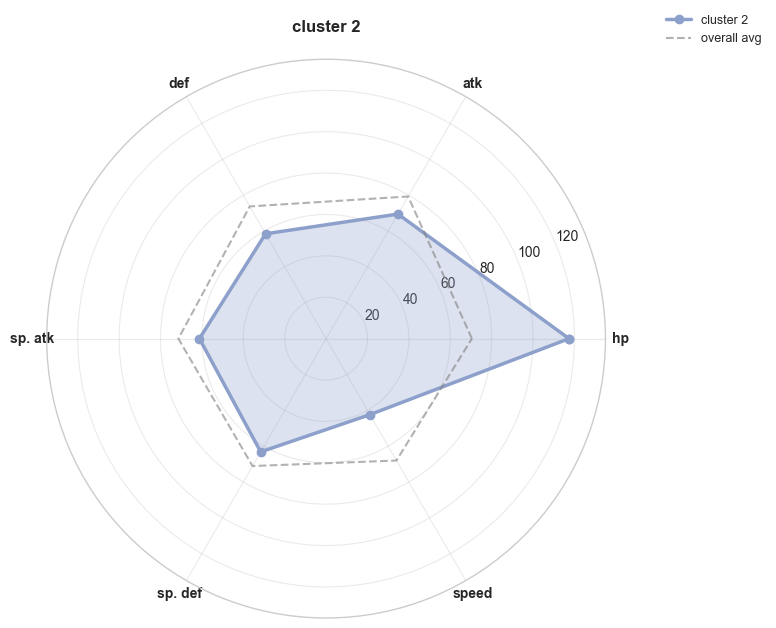

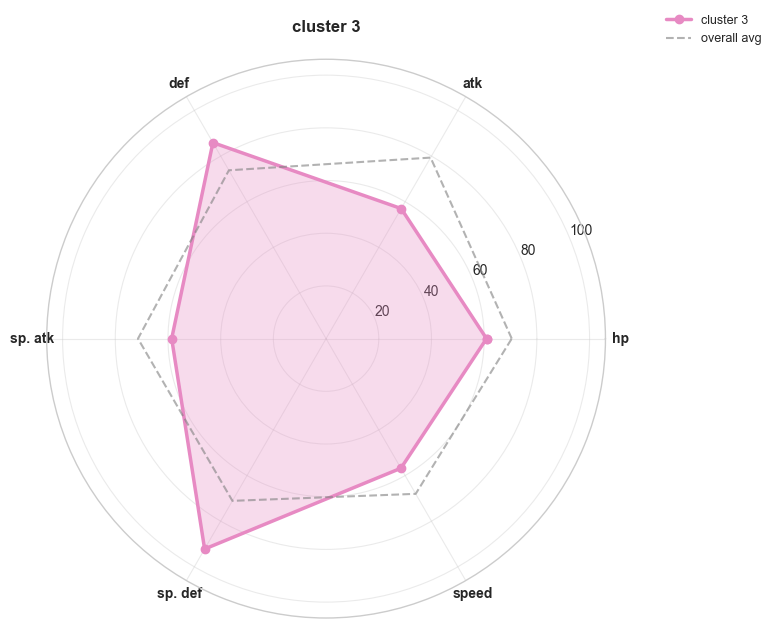

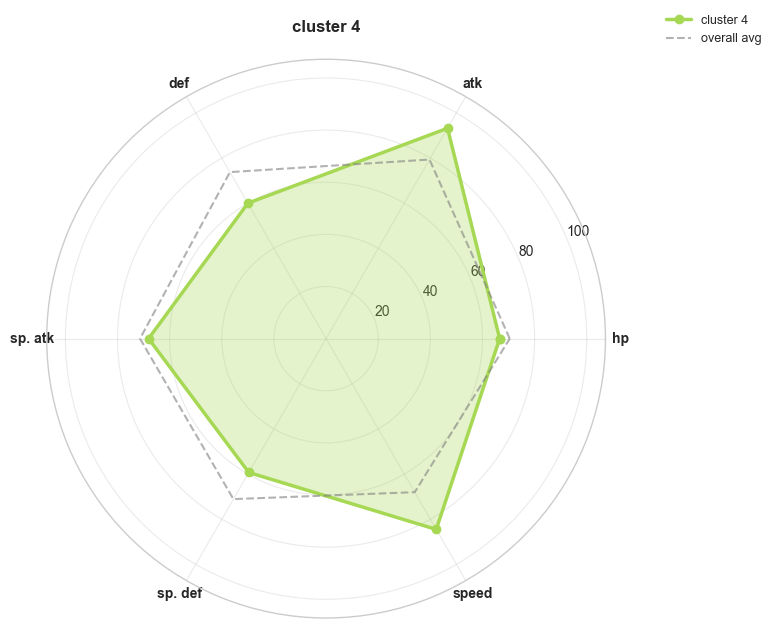

radar charts show distinct stat patterns for each cluster
shape differences indicate different pokemon archetypes


In [8]:
# create radar charts for clusters
from math import pi

categories = [get_short_stat_label(s) for s in base_stats_cols]
N = len(categories)

# get overall average for comparison
overall_avg = df[base_stats_cols].mean()

# create individual radar chart for each cluster
for cluster in range(optimal_k):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # get cluster average stats
    cluster_avg = cluster_stats.loc[cluster, base_stats_cols].values
    
    # set up angles for radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    cluster_avg_plot = list(cluster_avg)
    cluster_avg_plot += cluster_avg_plot[:1]  # complete the circle
    angles_plot = angles + angles[:1]
    
    # also plot overall average for comparison
    overall_vals = list(overall_avg.values)
    overall_vals += overall_vals[:1]
    
    # plot
    ax.plot(angles_plot, cluster_avg_plot, 'o-', linewidth=2.5, color=presentation_palette[cluster % len(presentation_palette)], 
            label=f'cluster {cluster}')
    ax.fill(angles_plot, cluster_avg_plot, alpha=0.3, color=presentation_palette[cluster % len(presentation_palette)])
    ax.plot(angles_plot, overall_vals, '--', linewidth=1.5, color='gray', alpha=0.6, label='overall avg')
    
    # fix axis
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, size=10, fontweight='bold')
    ax.set_ylim(0, max(max(cluster_avg_plot), max(overall_vals)) * 1.15)
    ax.set_title(f'cluster {cluster}', size=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.grid(True, alpha=0.4)
    
    plt.tight_layout()
    plt.savefig(f'figures/clustering/cluster_{cluster}_radar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

print("radar charts show distinct stat patterns for each cluster")
print("shape differences indicate different pokemon archetypes")

## Naming Pokemon Archetypes

In [9]:
# identify archetypes based on specialization patterns
archetype_interpretations = []

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    stats = cluster_stats.loc[cluster, base_stats_cols]
    spec_pattern = cluster_features.loc[cluster]
    
    # identify archetype based on specialization focus
    offense_focus = spec_pattern['Offense Focus']
    defense_focus = spec_pattern['Defense Focus']
    speed_focus = spec_pattern['Speed Focus']
    health_focus = spec_pattern['Health Focus']
    phys_vs_spec = spec_pattern['Physical vs Special']
    off_vs_def = spec_pattern['Offensive vs Defensive']
    
    # determine primary role
    if defense_focus > 0.40 and health_focus > 0.20:
        archetype = "tank / wall"
        description = "high defense and hp, built to take hits"
    elif offense_focus > 0.45 and defense_focus < 0.30:
        archetype = "glass cannon"
        description = "high offense, low defense - hits hard but fragile"
    elif speed_focus > 0.23:
        if offense_focus > 0.40:
            archetype = "speedster / sweeper"
            description = "fast offensive pokemon, strikes first"
        else:
            archetype = "support / utility"
            description = "fast but not offense-focused, likely for support"
    elif offense_focus > 0.40 and defense_focus > 0.35:
        archetype = "bruiser / balanced offensive"
        description = "good offense with decent bulk"
    elif abs(offense_focus - defense_focus) < 0.05:
        archetype = "balanced / generalist"
        description = "evenly distributed stats, no clear specialty"
    elif off_vs_def > 0.05:
        archetype = "offensive specialist"
        description = "focused on dealing damage"
    elif off_vs_def < -0.05:
        archetype = "defensive specialist"
        description = "focused on survivability"
    else:
        archetype = "mixed role"
        description = "moderate specialization"
    
    # add physical vs special distinction
    if abs(phys_vs_spec) > 0.2:
        if phys_vs_spec > 0:
            archetype += " (physical)"
        else:
            archetype += " (special)"
    
    # get highest and lowest stats
    highest_stat = get_short_stat_label(stats.idxmax())
    lowest_stat = get_short_stat_label(stats.idxmin())
    
    # legendary distribution
    legendary_ratio = (cluster_data['Is Legendary'].sum() / len(cluster_data)) * 100
    
    archetype_interpretations.append({
        'cluster': cluster,
        'archetype': archetype,
        'description': description,
        'size': len(cluster_data),
        'avg total stats': round(stats.sum(), 1),
        'highest stat': f"{highest_stat} ({stats.max():.1f})",
        'lowest stat': f"{lowest_stat} ({stats.min():.1f})",
        'offense focus': f"{offense_focus:.1%}",
        'defense focus': f"{defense_focus:.1%}",
        'speed focus': f"{speed_focus:.1%}",
        'legendary %': f"{legendary_ratio:.1f}%"
    })

archetype_df = pd.DataFrame(archetype_interpretations)
print("pokemon archetypes based on stat specialization patterns:")
print("=" * 120)
display(archetype_df)

print("\n" + "=" * 120)
print("key insight: clusters represent ROLES (tank, glass cannon, speedster)")
print("not power levels - legendaries are distributed across multiple archetypes")

pokemon archetypes based on stat specialization patterns:


,cluster,archetype,description,size,avg total stats,highest stat,lowest stat,offense focus,defense focus,speed focus,legendary %
0,0,balanced / generalist (physical),"evenly distributed stats, no clear specialty",218,438.0,atk (98.4),sp. atk (52.8),34.5%,36.4%,12.6%,6.0%
1,1,balanced / generalist,"evenly distributed stats, no clear specialty",292,450.8,sp. atk (97.9),atk (66.1),36.2%,32.2%,16.3%,13.7%
2,2,balanced / generalist,"evenly distributed stats, no clear specialty",62,412.2,hp (117.4),speed (42.4),31.6%,29.6%,10.3%,9.7%
3,3,defensive specialist,focused on survivability,165,411.4,sp. def (92.2),speed (56.8),27.8%,43.1%,14.3%,10.3%
4,4,offensive specialist,focused on dealing damage,288,431.7,atk (93.2),sp. def (59.3),37.0%,27.6%,19.9%,9.4%



key insight: clusters represent ROLES (tank, glass cannon, speedster)
not power levels - legendaries are distributed across multiple archetypes


## Legendary Pokemon Distribution

legendary pokemon distribution by cluster:


,legendary count,total pokemon,legendary ratio
Cluster,,,
0,13,218,0.060
1,40,292,0.137
2,6,62,0.097
3,17,165,0.103
4,27,288,0.094


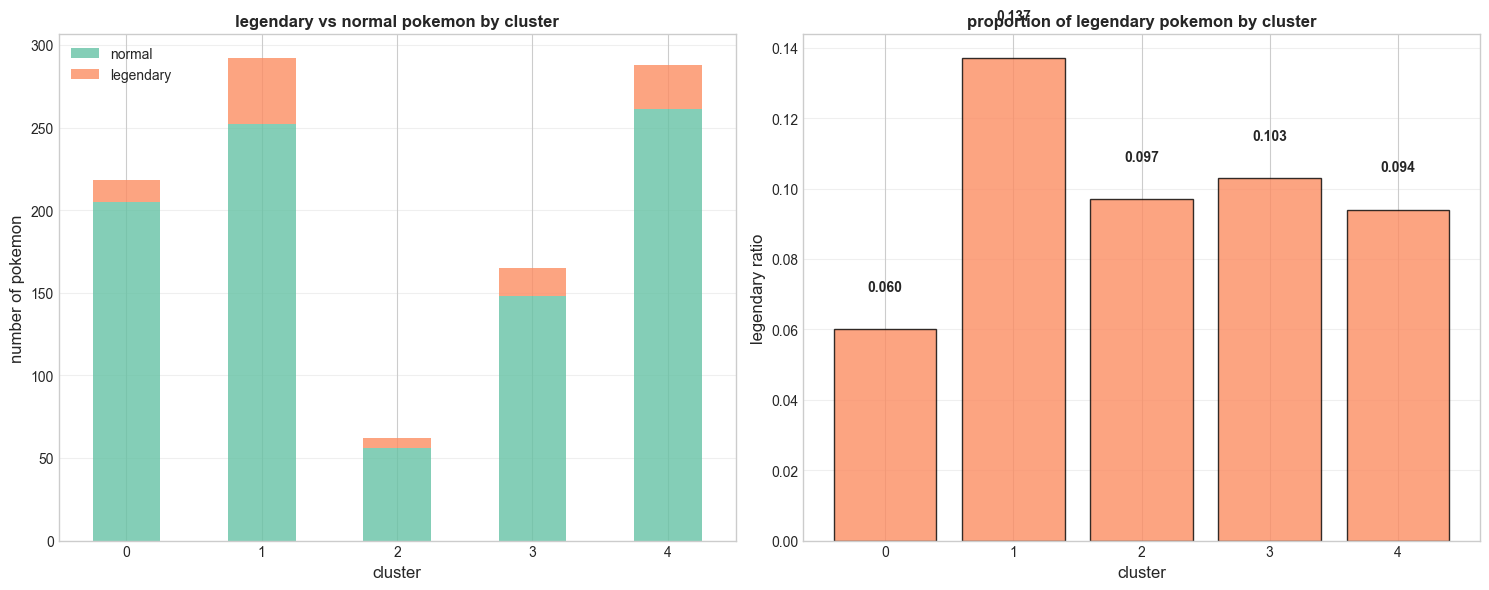


legendary distribution insight:
legendaries are MORE EVENLY distributed across clusters
clustering by ROLE, not power - legendary tanks cluster with normal tanks


In [10]:
# analyze legendary distribution across role-based clusters
legendary_by_cluster_spec = df.groupby('Cluster')['Is Legendary'].agg(['sum', 'count', 'mean']).round(3)
legendary_by_cluster_spec.columns = ['legendary count', 'total pokemon', 'legendary ratio']

print("legendary pokemon distribution by cluster:")
display(legendary_by_cluster_spec)

# visualize legendary distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# stacked bar chart
cluster_legendary_spec = df.groupby(['Cluster', 'Is Legendary']).size().unstack(fill_value=0)
cluster_legendary_spec.plot(kind='bar', stacked=True, ax=ax1, 
                             color=[presentation_palette[0], presentation_palette[1]], alpha=0.8)
ax1.set_xlabel('cluster', fontsize=12)
ax1.set_ylabel('number of pokemon', fontsize=12)
ax1.set_title('legendary vs normal pokemon by cluster', fontsize=12, fontweight='bold')
ax1.legend(['normal', 'legendary'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.grid(True, alpha=0.3, axis='y')

# legendary ratio by cluster
bars = ax2.bar(range(optimal_k), legendary_by_cluster_spec['legendary ratio'], 
               color=presentation_palette[1], alpha=0.8, edgecolor='black')
ax2.set_xlabel('cluster', fontsize=12)
ax2.set_ylabel('legendary ratio', fontsize=12)
ax2.set_title('proportion of legendary pokemon by cluster', fontsize=12, fontweight='bold')
ax2.set_xticks(range(optimal_k))
ax2.set_xticklabels(range(optimal_k))
ax2.grid(True, alpha=0.3, axis='y')

# add value labels
for bar, ratio in zip(bars, legendary_by_cluster_spec['legendary ratio']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/clustering/legendary_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nlegendary distribution insight:")
print("legendaries are MORE EVENLY distributed across clusters")
print("clustering by ROLE, not power - legendary tanks cluster with normal tanks")

## Type Distribution Analysis

primary type distribution by cluster:


Primary Type,"""Bug""","""Dark""","""Dragon""","""Electric""","""Fairy""","""Fighting""","""Fire""","""Flying""","""Ghost""","""Grass""","""Ground""","""Ice""","""Normal""","""Poison""","""Psychic""","""Rock""","""Steel""","""Water"""
Cluster,,,,,,,,,,,,,,,,,,
0,25,15,9,3,3,22,4,2,7,15,17,8,12,10,1,25,18,22
1,14,11,6,30,13,1,25,4,17,31,1,18,15,7,43,7,8,41
2,0,2,2,1,1,2,0,0,3,5,2,4,20,5,3,1,1,10
3,23,8,1,2,9,3,4,0,7,24,7,1,11,7,10,14,10,24
4,21,13,17,22,3,16,26,3,3,28,11,7,53,15,5,11,1,33


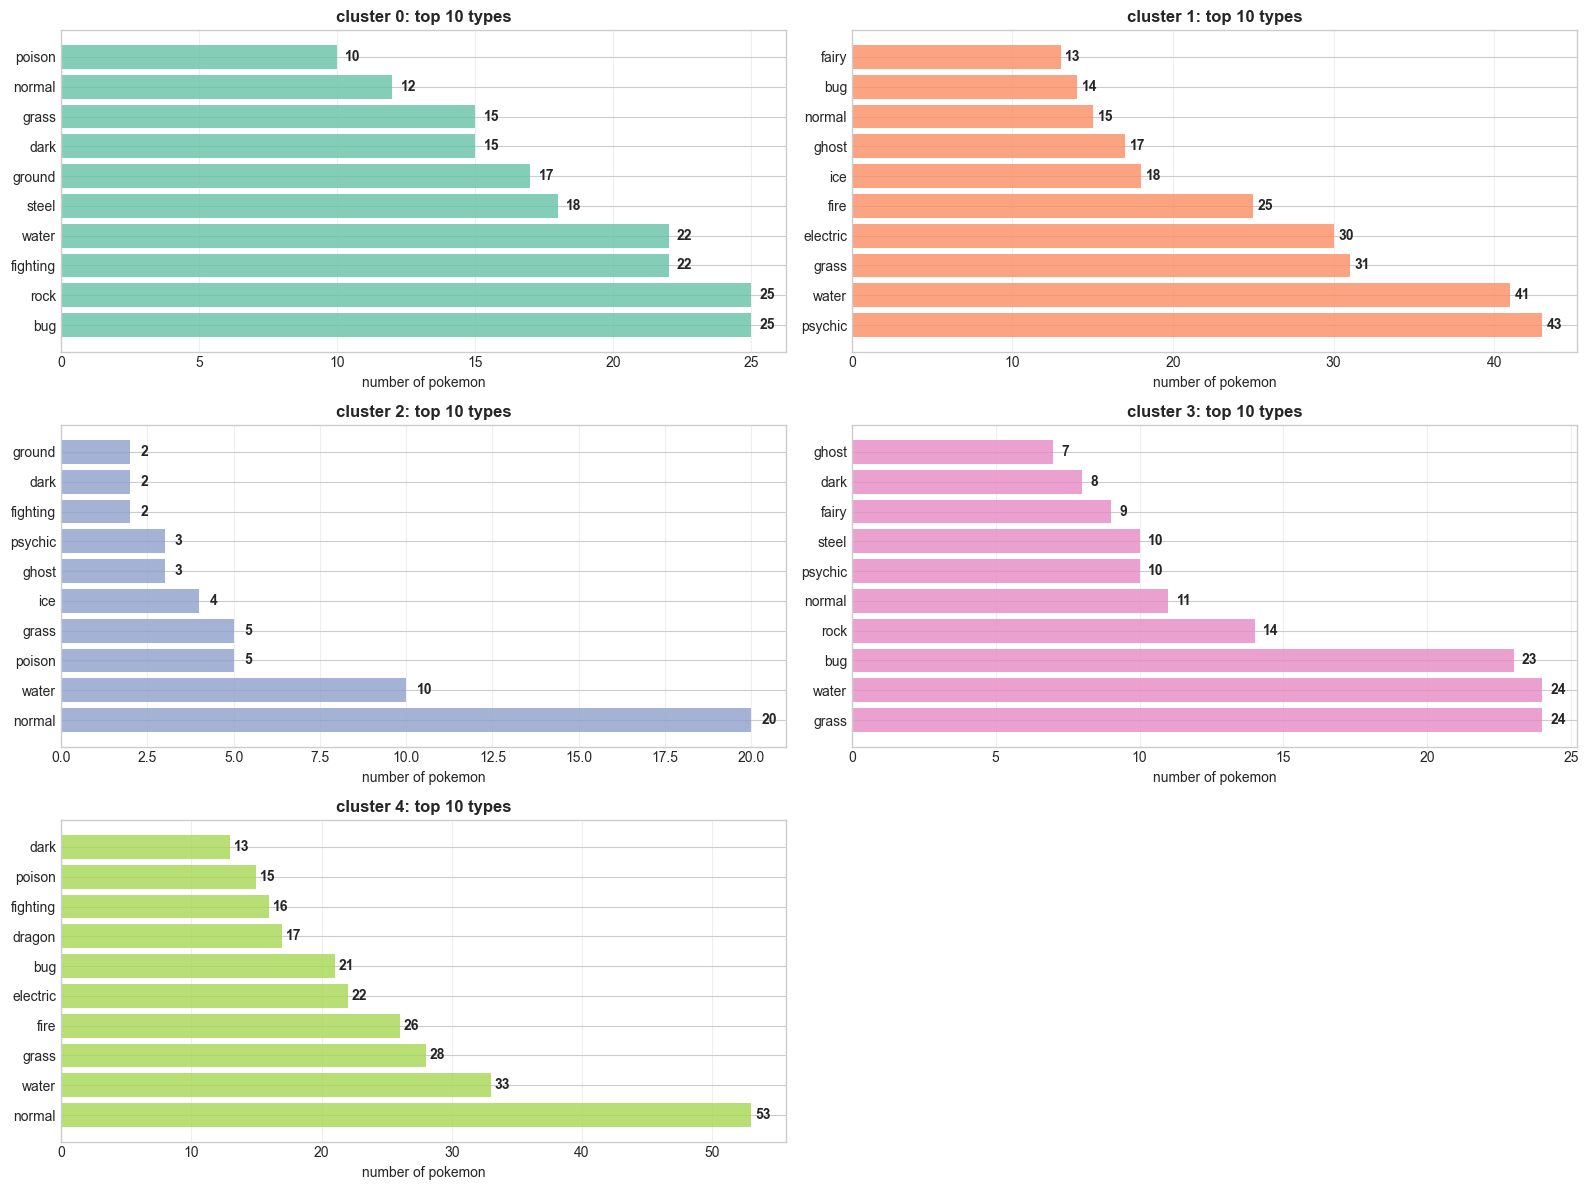


most common primary type per cluster:
  cluster 0: bug (25 pokemon)
  cluster 1: psychic (43 pokemon)
  cluster 2: normal (20 pokemon)
  cluster 3: grass (24 pokemon)
  cluster 4: normal (53 pokemon)


In [11]:
# analyze type distribution across clusters
type_by_cluster = df.groupby(['Cluster', 'Primary Type']).size().unstack(fill_value=0)

print("primary type distribution by cluster:")
display(type_by_cluster)

# visualize top types per cluster
fig, axes = plt.subplots((optimal_k + 1) // 2, 2, figsize=(16, 4 * ((optimal_k + 1) // 2)))
axes = axes.flatten() if optimal_k > 1 else [axes]

for cluster in range(optimal_k):
    cluster_types = type_by_cluster.loc[cluster].sort_values(ascending=False).head(10)
    
    axes[cluster].barh(range(len(cluster_types)), cluster_types.values, 
                       color=presentation_palette[cluster % len(presentation_palette)], alpha=0.8)
    axes[cluster].set_yticks(range(len(cluster_types)))
    axes[cluster].set_yticklabels([t.strip('"').lower() for t in cluster_types.index])
    axes[cluster].set_xlabel('number of pokemon')
    axes[cluster].set_title(f'cluster {cluster}: top 10 types', fontweight='bold')
    axes[cluster].grid(True, alpha=0.3, axis='x')
    
    # add value labels
    for i, count in enumerate(cluster_types.values):
        axes[cluster].text(count + 0.3, i, f'{count}', ha='left', va='center', fontweight='bold')

# hide extra subplots if optimal_k is odd
if optimal_k % 2 == 1:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('figures/clustering/type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# most common type per cluster
print("\nmost common primary type per cluster:")
for cluster in range(optimal_k):
    top_type = type_by_cluster.loc[cluster].idxmax()
    top_count = type_by_cluster.loc[cluster].max()
    print(f"  cluster {cluster}: {top_type.strip('\"').lower()} ({top_count} pokemon)")

## Visualizing Clusters in 2D: PCA

pca explained variance ratio: [0.33096297 0.31894372]
total variance explained: 0.650


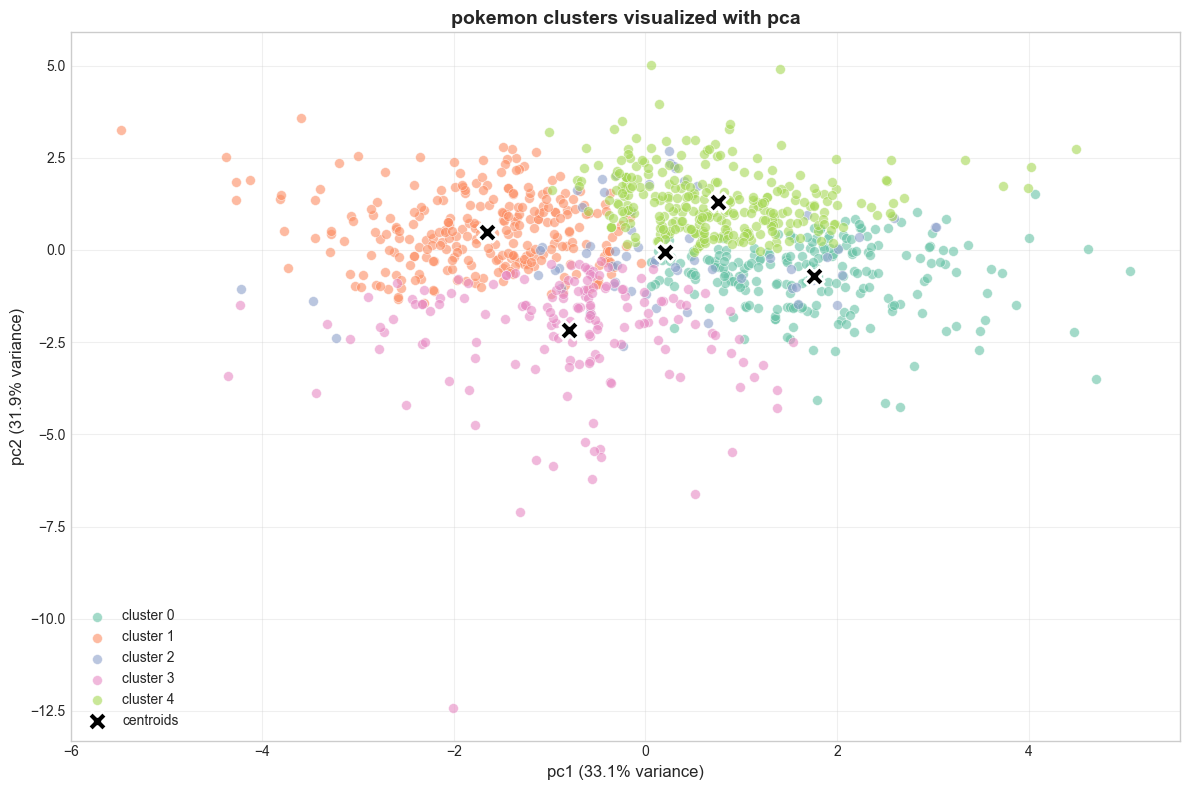

In [12]:
# reduce dimensionality with pca for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"pca explained variance ratio: {pca.explained_variance_ratio_}")
print(f"total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# create pca visualization
plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    mask = df['Cluster'] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[presentation_palette[cluster % len(presentation_palette)]], 
                label=f'cluster {cluster}', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)

# plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='X', s=200, 
            edgecolors='white', linewidth=2, label='centroids')

plt.xlabel(f'pc1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'pc2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('pokemon clusters visualized with pca', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/clustering/clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualizing Clusters in 2D: t-SNE

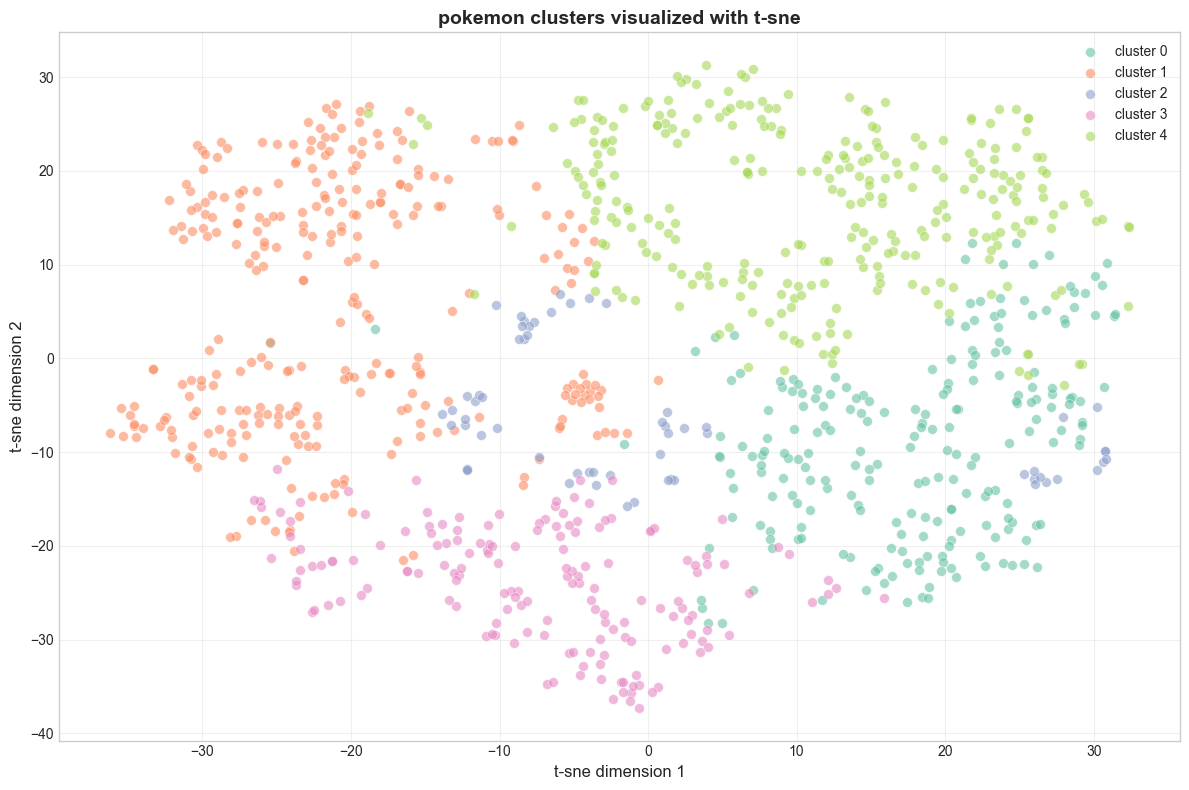

t-sne preserves local structure better than pca
helps visualize cluster separation and overlap


In [13]:
# reduce dimensionality with t-sne for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# create t-sne visualization
plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    mask = df['Cluster'] == cluster
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                c=[presentation_palette[cluster % len(presentation_palette)]], 
                label=f'cluster {cluster}', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)

plt.xlabel('t-sne dimension 1', fontsize=12)
plt.ylabel('t-sne dimension 2', fontsize=12)
plt.title('pokemon clusters visualized with t-sne', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/clustering/clusters_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-sne preserves local structure better than pca")
print("helps visualize cluster separation and overlap")

## Clustering Summary

In [14]:
# comprehensive clustering summary
print("clustering analysis summary")
print("=" * 60)
print(f"\noptimal number of clusters: {optimal_k}")
print(f"silhouette score: {final_silhouette:.4f}")
print(f"\ncluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"  cluster {cluster}: {count} pokemon ({count/len(df)*100:.1f}%)")

# identify legendary-heavy cluster
legendary_cluster = legendary_by_cluster_spec['legendary ratio'].idxmax()

print(f"\nkey findings:")
print(f"  • pca variance explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"  • legendary-heavy cluster: cluster {legendary_cluster} ({legendary_by_cluster_spec.loc[legendary_cluster, 'legendary ratio']:.1%} legendary)")
print(f"  • clusters represent pokemon ROLES/archetypes (tank, sweeper, etc.)")
print(f"  • specialization-based clustering reveals battle strategies")
print(f"  • type distribution varies across clusters but not perfectly aligned")

# presentation insights for 10-minute presentation
presentation_insights = pd.DataFrame({
    'section': [
        '1. motivation & approach',
        '2. determining optimal k',
        '3. cluster validation',
        '4. understanding clusters',
        '5. archetype naming',
        '6. insights & implications'
    ],
    'key visuals': [
        'preprocessing approach: specialization features',
        'elbow method + silhouette analysis graphs',
        'silhouette plot showing cluster quality',
        'heatmap + deviation charts + radar charts',
        'archetype summary table with roles',
        'legendary distribution + type distribution'
    ],
    'talking points': [
        'clustering by stat PROPORTIONS, not absolute power - reveals roles',
        'chose k=5 based on silhouette score, balancing interpretability',
        'silhouette score validates reasonable cluster separation',
        'each cluster has distinct stat signature (deviations from mean)',
        'meaningful names: tank, glass cannon, speedster, bruiser, etc.',
        'legendaries spread across roles; types loosely align with archetypes'
    ]
})

print("\npresentation structure:")
display(presentation_insights)

print("\nkey message for presentation:")
print("specialization-based clustering reveals pokemon BATTLE ROLES")
print("not just power tiers - weak and strong pokemon can share the same archetype")

clustering analysis summary

optimal number of clusters: 5
silhouette score: 0.1969

cluster sizes:
  cluster 0: 218 pokemon (21.3%)
  cluster 1: 292 pokemon (28.5%)
  cluster 2: 62 pokemon (6.0%)
  cluster 3: 165 pokemon (16.1%)
  cluster 4: 288 pokemon (28.1%)

key findings:
  • pca variance explained: 65.0%
  • legendary-heavy cluster: cluster 1 (13.7% legendary)
  • clusters represent pokemon ROLES/archetypes (tank, sweeper, etc.)
  • specialization-based clustering reveals battle strategies
  • type distribution varies across clusters but not perfectly aligned

presentation structure:


,section,key visuals,talking points
0,1. motivation & approach,preprocessing approach: specialization features,"clustering by stat PROPORTIONS, not absolute power - reveals roles"
1,2. determining optimal k,elbow method + silhouette analysis graphs,"chose k=5 based on silhouette score, balancing interpretability"
2,3. cluster validation,silhouette plot showing cluster quality,silhouette score validates reasonable cluster separation
3,4. understanding clusters,heatmap + deviation charts + radar charts,each cluster has distinct stat signature (deviations from mean)
4,5. archetype naming,archetype summary table with roles,"meaningful names: tank, glass cannon, speedster, bruiser, etc."
5,6. insights & implications,legendary distribution + type distribution,legendaries spread across roles; types loosely align with archetypes



key message for presentation:
specialization-based clustering reveals pokemon BATTLE ROLES
not just power tiers - weak and strong pokemon can share the same archetype
